## Importing packages and looking at data  

First, import all neccessary packages and define all the variables.

In [10]:
import os
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [11]:
#all variables
data_classified = 'Data/classified'
data_raw = 'Data/raw'
data_alpha = 'Data/diversity'
data_abundance ='Data/abundance'

The biggest differences were found between the sterile and non-sterile environment during beta-
diversity analysis, so these will be looked at. 

In [12]:
#First, we look at the distribution of our data. 
data = q2.Artifact.load(f'{data_raw}/modified-dada1-table-highschool.qza').view(pd.DataFrame)

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [23]:
data.shape

NameError: name 'data' is not defined

In [24]:
data
# Get the top three most abundant sequence variants
# based on sum of observed sequence counts. Create a dataframe of ASV counts 
# with samples as rows and sequence variants as columns.
top_three = data[data.sum().nlargest(3).index]
# Your turn to try! Now view each of them as a histogram, as number of samples per ASV.
# View each as a histogram showing number of samples per ASV count value
import matplotlib.pyplot as plt

top_asv_names = top_three.columns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))


for i, asv in enumerate(top_asv_names):
    axes[i].hist(top_three[asv], bins=20, edgecolor='black')
    axes[i].set_xlabel('ASV Count')
    axes[i].set_ylabel('Number of Samples')
    axes[i].set_title(f'ASV {i+1}')

plt.tight_layout()
plt.show()

# Print the actual ASV identifiers
print("\nTop 3 ASV identifiers:")
for i, asv in enumerate(top_asv_names, 1):
    print(f"{i}. {asv} (total: {data[asv].sum()})")

NameError: name 'data' is not defined

## Filtering and first ANCOM BC

In [16]:
#based on the shape of the data and the distribution of above, the following parameters for
#filtering were chosen
! qiime feature-table filter-features \
  --i-table $data_classified/table-filtered.qza \
  --p-min-frequency 50 \
  --p-min-samples 10 \
  --o-filtered-table $data_abundance/table_abund.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_abund.qza


In [7]:
#Check if there are any other values than sterile and non-sterile in the merged metadata in the background column
md_merged = pd.read_csv(f'{data_raw}/merged_output_usable.tsv', sep='\t')
md_merged['background'].unique()

array(['non-sterile', 'sterile', nan], dtype=object)

In [28]:

#we want to look at differences betwen non-sterile and sterile environment, since nan values are in df, filter for 
#sterile and non-sterile values
! qiime feature-table filter-samples \
    --i-table $data_abundance/table_abund.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-where "[background]='sterile' OR [background]='non-sterile'" \
    --o-filtered-table $data_abundance/table_abund_sterile_nonsterile.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
^C
R[write to console]: 

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/q2cli/util.py", line 275, in get_plugin_manager
    return qiime2.sdk.PluginManager.reuse_existing()
  File "/opt/conda/lib/python3.10/site-packages/qiime2/sdk/plugin_manager.py", line 58, in reuse_existing
    raise UninitializedPluginManagerError
qiime2.sdk.plugin_manager.UninitializedPluginManagerError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/q2cli/click/type.py", line 117, in _convert_input
    result, error = q2cli.util._load_input(value)
  F

In [18]:

#make it into a visualization
! qiime feature-table summarize \
    --i-table $data_abundance/table_abund_sterile_nonsterile.qza \
    --m-sample-metadata-file $data_raw/merged_output_usable.tsv \
    --o-visualization $data_abundance/table_abund_sterile_nonsterile.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/abundance/table_abund_sterile_nonsterile.qzv


In [21]:

# Run ANCOM-BC to test which ASVs differ between sterile and non-sterile
#first we start with an overall background comparison
! qiime composition ancombc \
    --i-table $data_abundance/table_abund_sterile_nonsterile.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-formula background \
    --o-differentials $data_abundance/ancombc_sterile_nonsterile_differentials.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_differentials.qza


In [30]:

# Generate a barplot of differentially abundant taxa between sterile and non-sterile backgrounds
! qiime composition da-barplot \
    --i-data $data_abundance/ancombc_sterile_nonsterile_differentials.qza \
    --o-visualization $data_abundance/ancombc_sterile_nonsterile_da_barplot.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/abundance/ancombc_sterile_nonsterile_da_barplot.qzv


In [9]:

Visualization.load(f"{data_abundance}/ancombc_sterile_nonsterile_da_barplot.qzv")

ValueError: FermentYOU/Data/abundance/ancombc_sterile_nonsterile_da_barplot.qzv does not exist.

## ANCOM BC to see differences on species level between sterile and non-sterile

Now we did a general analysis, and saw there were definetly some samples
enriched vs. depleted in the analysis. Now we want to try and answer the 
following questions by differential abundance: 
2. How did the fungal communities change over time between sterile vs.
non-sterile starter backgrounds? Is one background more ‘resilient’ towards
invading fungi directly coming from participants' hands?
3. Which taxa consistently transfer from hand to dough — and which resist
colonization?

We try to answer this question first:  2. How did the fungal communities change over time between sterile vs.
non-sterile starter backgrounds? Is one background more ‘resilient’ towards
invading fungi directly coming from participants' hands?
For this, we want to run a ANCOM bc test between sterile vs non-sterile background
at the different time points (we have the time points 0, 7, 14 and 21)

In [33]:
#Some data in the day column are empty, so first we need to filter the metadata df for only 
#data where there is a time point
md_time = pd.read_csv(f'{data_raw}/merged_output_usable.tsv', sep='\t')
# Drop rows where 'day' column is missing/empty
md_time = md_time[md_time['day'].notna()].copy()
# Save to new file
md_time.to_csv(f'{data_raw}/md_time.tsv', sep='\t', index=False)

For loop through each time point, to run ANCOM BC test at each time point for sterile 
and non-sterile environment. 

In [35]:
import os
#Not really sure whether it still makes sense to do this, 
#as we really are interested in the species. 

# Different time points 
days = [0, 7, 14, 21]

# Loop through each day
for day in days:
    print(f"Processing day {day}...")
    
    # Filter for current day samples
    os.system(f"""qiime feature-table filter-samples \
        --i-table {data_abundance}/table_abund_sterile_nonsterile.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-where "[day]='{day}'" \
        --o-filtered-table {data_abundance}/table_abund_sterile_nonsterile_day{day}.qza""")
    
    # Run ANCOM-BC on current day
    os.system(f"""qiime composition ancombc \
        --i-table {data_abundance}/table_abund_sterile_nonsterile_day{day}.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-formula background \
        --o-differentials {data_abundance}/ancombc_sterile_nonsterile_day{day}_differentials.qza""")
    
    print(f"Completed day {day}\n")

print("All days processed!")

Processing day 0...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day0.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day0_differentials.qza
Completed day 0

Processing day 7...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day7.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day7_differentials.qza
Completed day 7

Processing day 14...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day14.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day14_differentials.qza
Completed day 14

Processing day 21...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day21.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day21_differentials.qza
Completed day 21

All days processed!


## Analysis on the species level

Now, let's do the same with species identification. For this we need to collapse the 
table on species level. 

In [34]:

! qiime taxa collapse \
    --i-table $data_abundance/table_abund.qza \
    --i-taxonomy $data_classified/taxonomy.qza \
    --p-level 7 \
    --o-collapsed-table $data_abundance/table_abund_l7.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_abund_l7.qza


In [4]:
#Export the results
import os

# Export each time point's results
days = [0, 7, 14, 21]
for day in days:
    os.system(f"""
        qiime tools export \
            --input-path {data_abundance}/ancombc_sterile_nonsterile_day{day}_differentials.qza \
            --output-path {data_abundance}/exported_day{day}
    """)

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_day0_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_day0


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources

Aborted!
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_day14_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_day14


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_day21_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_day21


In [ ]:
import os

# Define the days to process
days = [0, 7, 14, 21]

# Loop through each day
for day in days:
    print(f"Processing day {day}...")
    
    # Filter for current day samples
    status1 = os.system(f"""qiime feature-table filter-samples \
        --i-table {data_abundance}/table_abund_l7.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-where "[day]='{day}'" \
        --o-filtered-table {data_abundance}/table_abund_sterile_nonsterile_l7_day{day}.qza""")
    
    if status1 != 0:
        print(f"Error filtering day {day}")
        continue
    
    # Run ANCOM-BC on current day
    status2 = os.system(f"""qiime composition ancombc \
        --i-table {data_abundance}/table_abund_sterile_nonsterile_l7_day{day}.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-formula background \
        --o-differentials {data_abundance}/ancombc_sterile_nonsterile_l7_day{day}_differentials.qza""")
    
    if status2 != 0:
        print(f"Error running ANCOM-BC for day {day}")
    else:
        print(f"✓ Completed day {day}\n")

print("All days processed!")

Processing day 0...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_l7_day0.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_l7_day0_differentials.qza
✓ Completed day 0

Processing day 7...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_l7_day7.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources

Aborted!


Error running ANCOM-BC for day 7
Processing day 14...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_l7_day14.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [5]:


# Export each time point's results
days = [0, 7, 14, 21]

for day in days:
    print(f"Exporting day {day} results...")
    
    status = os.system(f"""qiime tools export \
        --input-path {data_abundance}/ancombc_sterile_nonsterile_l7_day{day}_differentials.qza \
        --output-path {data_abundance}/exported_l7_day{day}""")
    
    if status != 0:
        print(f"Error exporting day {day}")
    else:
        print(f"✓ Exported day {day}\n")

print("All exports completed!")

Exporting day 0 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_l7_day0_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_day0
✓ Exported day 0

Exporting day 7 results...
Error exporting day 7
Exporting day 14 results...


Usage: qiime tools export [OPTIONS]

  Exporting extracts (and optionally transforms) data stored inside an
  Artifact or Visualization. Note that Visualizations cannot be transformed
  with --output-format

Options:
  --input-path ARTIFACT/VISUALIZATION
                        Path to file that should be exported        [required]
  --output-path PATH    Path to file or directory where data should be
                        exported to                                 [required]
  --output-format TEXT  Format which the data should be exported as. This
                        option cannot be used with Visualizations
  --help                Show this message and exit.

                    There was a problem with the command:                     
 (1/1) Invalid value for '--input-path': File
  'Data/abundance/ancombc_sterile_nonsterile_l7_day7_differentials.qza' does
  not exist.
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as a

Exported Data/abundance/ancombc_sterile_nonsterile_l7_day14_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_day14
✓ Exported day 14

Exporting day 21 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_l7_day21_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_day21
✓ Exported day 21

All exports completed!


In [8]:
# Load the differential species abundance results for each time point
days = [0, 7, 14, 21]
results_species_level = {}

for day in days:
    lfc = pd.read_csv(f"{data_abundance}/exported_dayl7{day}/lfc_slice.csv", index_col=0)
    p_val = pd.read_csv(f"{data_abundance}/exported_day{day}/p_val_slice.csv", index_col=0)
    q_val = pd.read_csv(f"{data_abundance}/exported_day{day}/q_val_slice.csv", index_col=0)
    se = pd.read_csv(f"{data_abundance}/exported_day{day}/se_slice.csv", index_col=0)
    w = pd.read_csv(f"{data_abundance}/exported_day{day}/w_slice.csv", index_col=0)
    
    df = pd.DataFrame({
        'lfc': lfc.iloc[:, 0],
        'p_val': p_val.iloc[:, 0],
        'q_val': q_val.iloc[:, 0],
        'se': se.iloc[:, 0],
        'w': w.iloc[:, 0]
    })
    df.index.name = 'id'
    df = df.reset_index()
    results_species_level[day] = df

FileNotFoundError: [Errno 2] No such file or directory: 'FermentYOU/Data/abundance/exported_dayl70/lfc_slice.csv'

In [45]:
# Create heatmap matrix

heatmap_data = []
for day, df in results_species_level.items():
    significant = df[df['q_val'] < 0.05].copy()
    significant['day'] = f'Day {day}'
    
    # Extract ONLY genus and species
    def extract_genus_species(tax_string):
        parts = tax_string.split(';')
        genus = [p for p in parts if p.startswith('g__')]
        species = [p for p in parts if p.startswith('s__')]
        
        genus_name = genus[0].replace('g__', '').strip() if genus else ''
        species_name = species[0].replace('s__', '').strip() if species else ''
        
        if genus_name and species_name and species_name != '':
            return f"{genus_name} {species_name}"
        elif genus_name and genus_name != '':
            return genus_name
        else:
            return None
    
    significant['display_name'] = significant['id'].apply(extract_genus_species)
    significant = significant[significant['display_name'].notna()]
    
    heatmap_data.append(significant[['display_name', 'lfc', 'day']])

combined = pd.concat(heatmap_data, ignore_index=True)

# Filter for top taxa by absolute log-fold change
top_n = 30  # Adjust this number as needed
mean_abs_lfc = combined.groupby('display_name')['lfc'].apply(lambda x: abs(x).mean())
top_taxa = mean_abs_lfc.nlargest(top_n).index
combined_filtered = combined[combined['display_name'].isin(top_taxa)]

heatmap_matrix = combined_filtered.pivot(index='display_name', columns='day', values='lfc')

# Sort columns by day order
day_order = ['Day 0', 'Day 7', 'Day 14', 'Day 21']
heatmap_matrix = heatmap_matrix.reindex(columns=day_order)

# Sort rows by hierarchical clustering or by mean LFC
row_order = heatmap_matrix.mean(axis=1).sort_values(ascending=False).index
heatmap_matrix = heatmap_matrix.reindex(row_order)

# Create heatmap with larger figure
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_matrix, cmap='RdBu_r', center=0, 
            cbar_kws={'label': 'Log-fold change (sterile vs non-sterile)'},
            linewidths=0.5, yticklabels=True)
plt.title(f'Top {top_n} Fungal Species: Sterile vs Non-Sterile Backgrounds Over Time')
plt.xlabel('Time Point')
plt.ylabel('Fungal Species')
plt.tight_layout()
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1200x1000 with 0 Axes>

In [ ]:
#Load the ASV level assignment into pandas 
import pandas as pd days = [0, 7, 14, 21] 
# Load the differential abundance results for each time point 
results = {} for day in days: 
# Read all the slice files
lfc = pd.read_csv(f"{data_abundance}/exported_day{day}/lfc_slice.csv", index_col=0)
p_val = pd.read_csv(f"{data_abundance}/exported_day{day}/p_val_slice.csv", index_col=0) 
q_val = pd.read_csv(f"{data_abundance}/exported_day{day}/q_val_slice.csv", index_col=0) 
se = pd.read_csv(f"{data_abundance}/exported_day{day}/se_slice.csv", index_col=0)
w = pd.read_csv(f"{data_abundance}/exported_day{day}/w_slice.csv", index_col=0) 
# Combine into one dataframe
df = pd.DataFrame({ 'lfc': lfc.iloc[:, 0], 'p_val': p_val.iloc[:, 0], 'q_val': q_val.iloc[:, 0], 'se': se.iloc[:, 0], 'w': w.iloc[:, 0] }) 
df.index.name = 'id' df = df.reset_index()
results[day] = df

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# 1. Count significant taxa at each time point
q_threshold = 0.05
significant_counts = []

for day in days:
    n_sig = (results[day]['q_val'] < q_threshold).sum()
    significant_counts.append(n_sig)
    print(f"Day {day}: {n_sig} significant taxa")

# 2. Create a simple line plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(days, significant_counts, marker='o', linewidth=3, markersize=12, 
        color='#2E86AB')
ax.fill_between(days, 0, significant_counts, alpha=0.3, color='#2E86AB')

ax.set_xlabel('Day', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Significantly Different Taxa', fontsize=14, fontweight='bold')
ax.set_title('Differences Between Sterile vs Non-Sterile Backgrounds Over Time\n(q < 0.05)', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(days)
ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add values on points
for day, count in zip(days, significant_counts):
    ax.text(day, count + max(significant_counts)*0.03, str(count), 
            ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig(f"{data_abundance}/community_resilience.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Interpretation
print("\n=== INTERPRETATION ===")
if significant_counts[-1] < significant_counts[0]:
    print("✓ Communities are CONVERGING (becoming more similar)")
    print("  → Both backgrounds show resilience - they adapt toward similar communities")
elif significant_counts[-1] > significant_counts[0]:
    print("✗ Communities are DIVERGING (becoming more different)")
    print("  → Backgrounds follow different trajectories - less resilient to invasion")
else:
    print("→ Differences remain STABLE over time")
    print("  → Persistent structural differences between backgrounds")

Day 0: 126 significant taxa
Day 7: 66 significant taxa
Day 14: 79 significant taxa
Day 21: 88 significant taxa

=== INTERPRETATION ===
✓ Communities are CONVERGING (becoming more similar)
  → Both backgrounds show resilience - they adapt toward similar communities


In [8]:
#evtl. buc neccessary
#check for unique values in the sample_type column
md_merged['sample_type'].unique()

array(['sourdough', 'control_n', 'control_pcr', 'control_p', 'empty',
       'hand_swabs'], dtype=object)

In [27]:

#evtl. general per veser ch'ei ha ina differenza
#Filter for hand_swabs and sourdough samples
! qiime feature-table filter-samples \
    --i-table $data_abundance/table_abund.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-where "[sample_type]='hand_swabs' OR [sample_type]='sourdough'" \
    --o-filtered-table $data_abundance/table_hand_dough.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_hand_dough.qza


In [4]:
! qiime composition ancombc \
    --i-table $data_abundance/table_hand_dough.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-formula "sample_type" \
    --p-reference-levels "sample_type::hand_swabs" \
    --o-differentials $data_abundance/table_hand_dough_person_filtered.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[DifferentialAbundance] to: Data/abundance/table_hand_dough_person_filtered.qza


In [5]:
#turn into visualization 
! qiime composition tabulate \
    --i-data $data_abundance/table_hand_dough_person_filtered.qza \
    --o-visualization $data_abundance/table_hand_dough_person_filtered.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/abundance/table_hand_dough_person_filtered.qzv


In [6]:
#Visualize
! qiime composition da-barplot \
    --i-data $data_abundance/table_hand_dough_person_filtered.qza \
    --o-visualization $data_abundance/ancombc_hand_dough_barplot.qzv


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/abundance/ancombc_hand_dough_barplot.qzv


In [1]:
Visualization.load(f"Data/abundance/table_hand_dough_person_filtered.qzv")

NameError: name 'Visualization' is not defined

In [4]:
Visualization.load(f"Data/abundance/ancombc_hand_dough_barplot.qzv")

<visualization: Visualization uuid: aacd0a5b-a024-4351-8a84-523800d65f99>

In [ ]:
#We saw there's a difference between hand_swabs and sourdoughs, now filter our data
#for taxa that are both present in sourdough and hand_swabs
#per dar risposta quei dus heatmaps nua che fetg comparen hand vs sourdough, inaga la analysa 
#cun sterile ed inaga cun nonsterile

In [14]:
#Looping through the different time points again for sourdough vs. hand_swabs for 
#the sterile environment
import os

# Define the days to process
days = [0, 7, 14, 21]

# Loop through each day
for day in days:
    print(f"Processing day {day}...")
    
    # Filter for current day samples (hand_swabs and sourdough only, sterile background)
    status1 = os.system(f"""qiime feature-table filter-samples \
        --i-table {data_abundance}/table_abund_l7.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-where "[day]='{day}' AND ([sample_type]='hand_swabs' OR [sample_type]='sourdough') AND [background]='sterile'" \
        --o-filtered-table {data_abundance}/table_abund_hand_vs_sourdough_l7_day{day}.qza""")
    
    if status1 != 0:
        print(f"Error filtering day {day}")
        continue
    
    # Run ANCOM-BC on current day (comparing sample_type instead of background)
    status2 = os.system(f"""qiime composition ancombc \
        --i-table {data_abundance}/table_abund_hand_vs_sourdough_l7_day{day}.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-formula sample_type \
        --o-differentials {data_abundance}/ancombc_l7_sterile_day{day}_differentials.qza""")
    
    if status2 != 0:
        print(f"Error running ANCOM-BC for day {day}")
    else:
        print(f"✓ Completed day {day}\n")

print("All days processed!")

Processing day 0...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day0.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Plugin error from composition:

  An error was encountered while running ANCOM-BC in R (return code 1), please inspect stdout and stderr to learn more.

Debug info has been saved to /tmp/qiime2-q2cli-err-j33ip44v.log


Error running ANCOM-BC for day 0
Processing day 7...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day7.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_hand_vs_sourdough_l7_day7_differentials.qza
✓ Completed day 7

Processing day 14...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day14.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_hand_vs_sourdough_l7_day14_differentials.qza
✓ Completed day 14

Processing day 21...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day21.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_hand_vs_sourdough_l7_day21_differentials.qza
✓ Completed day 21

All days processed!


In [ ]:
#And once for the non-sterile environment
import os

# Define the days to process
days = [0, 7, 14, 21]

# Loop through each day
for day in days:
    print(f"Processing day {day}...")
    
    # Filter for current day samples (hand_swabs and sourdough only, non-sterile background)
    status1 = os.system(f"""qiime feature-table filter-samples \
        --i-table {data_abundance}/table_abund_l7.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-where "[day]='{day}' AND ([sample_type]='hand_swabs' OR [sample_type]='sourdough') AND [background]='non-sterile'" \
        --o-filtered-table {data_abundance}/table_abund_hand_vs_sourdough_l7_day{day}.qza""")
    
    if status1 != 0:
        print(f"Error filtering day {day}")
        continue
    
    # Run ANCOM-BC on current day (comparing sample_type instead of background)
    status2 = os.system(f"""qiime composition ancombc \
        --i-table {data_abundance}/table_abund_hand_vs_sourdough_l7_day{day}.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-formula sample_type \
        --o-differentials {data_abundance}/ancombc_non_sterile_day{day}_differentials.qza""")
    
    if status2 != 0:
        print(f"Error running ANCOM-BC for day {day}")
    else:
        print(f"✓ Completed day {day}\n")

print("All days processed!")

In [15]:
import os
#need to adjust path for sterile and for non-sterile once 
# Export each time point's results
days = [0, 7, 14, 21]

for day in days:
    print(f"Exporting day {day} results...")
    
    status = os.system(f"""qiime tools export \
        --input-path {data_abundance}/ancombc_hand_vs_sourdough_l7_day{day}_differentials.qza \
        --output-path {data_abundance}/exported_hand_vs_sourdough_l7_day{day}""")
    
    if status != 0:
        print(f"Error exporting day {day}")
    else:
        print(f"✓ Exported day {day}\n")

print("All exports completed!")

Exporting day 0 results...
Error exporting day 0
Exporting day 7 results...


Usage: qiime tools export [OPTIONS]

  Exporting extracts (and optionally transforms) data stored inside an
  Artifact or Visualization. Note that Visualizations cannot be transformed
  with --output-format

Options:
  --input-path ARTIFACT/VISUALIZATION
                        Path to file that should be exported        [required]
  --output-path PATH    Path to file or directory where data should be
                        exported to                                 [required]
  --output-format TEXT  Format which the data should be exported as. This
                        option cannot be used with Visualizations
  --help                Show this message and exit.

                    There was a problem with the command:                     
 (1/1) Invalid value for '--input-path': File
  'Data/abundance/ancombc_hand_vs_sourdough_l7_day0_differentials.qza' does
  not exist.
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an

Exported Data/abundance/ancombc_hand_vs_sourdough_l7_day7_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_hand_vs_sourdough_l7_day7
✓ Exported day 7

Exporting day 14 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_hand_vs_sourdough_l7_day14_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_hand_vs_sourdough_l7_day14
✓ Exported day 14

Exporting day 21 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_hand_vs_sourdough_l7_day21_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_hand_vs_sourdough_l7_day21
✓ Exported day 21

All exports completed!


In [16]:
#here also need to adjust path for sterile and non-sterile once 
# Load the differential species abundance results for each time point (hand_swabs vs sourdough)
days = [7, 14, 21]  # Exclude day 0 since it failed
results_hand_vs_sourdough = {}

for day in days:
    lfc = pd.read_csv(f"{data_abundance}/exported_hand_vs_sourdough_l7_day{day}/lfc_slice.csv", index_col=0)
    p_val = pd.read_csv(f"{data_abundance}/exported_hand_vs_sourdough_l7_day{day}/p_val_slice.csv", index_col=0)
    q_val = pd.read_csv(f"{data_abundance}/exported_hand_vs_sourdough_l7_day{day}/q_val_slice.csv", index_col=0)
    se = pd.read_csv(f"{data_abundance}/exported_hand_vs_sourdough_l7_day{day}/se_slice.csv", index_col=0)
    w = pd.read_csv(f"{data_abundance}/exported_hand_vs_sourdough_l7_day{day}/w_slice.csv", index_col=0)
    
    df = pd.DataFrame({
        'lfc': lfc.iloc[:, 0],
        'p_val': p_val.iloc[:, 0],
        'q_val': q_val.iloc[:, 0],
        'se': se.iloc[:, 0],
        'w': w.iloc[:, 0]
    })
    df.index.name = 'id'
    df = df.reset_index()
    results_hand_vs_sourdough[day] = df

# Quick check
for day in days:
    significant = results_hand_vs_sourdough[day][results_hand_vs_sourdough[day]['q_val'] < 0.05]
    print(f"Day {day}: {len(significant)} significant taxa")
    print(f"  Enriched in sourdough: {(significant['lfc'] > 0).sum()}")
    print(f"  Enriched in hand_swabs: {(significant['lfc'] < 0).sum()}\n")

Day 7: 90 significant taxa
  Enriched in sourdough: 68
  Enriched in hand_swabs: 22

Day 14: 115 significant taxa
  Enriched in sourdough: 74
  Enriched in hand_swabs: 41

Day 21: 114 significant taxa
  Enriched in sourdough: 96
  Enriched in hand_swabs: 18



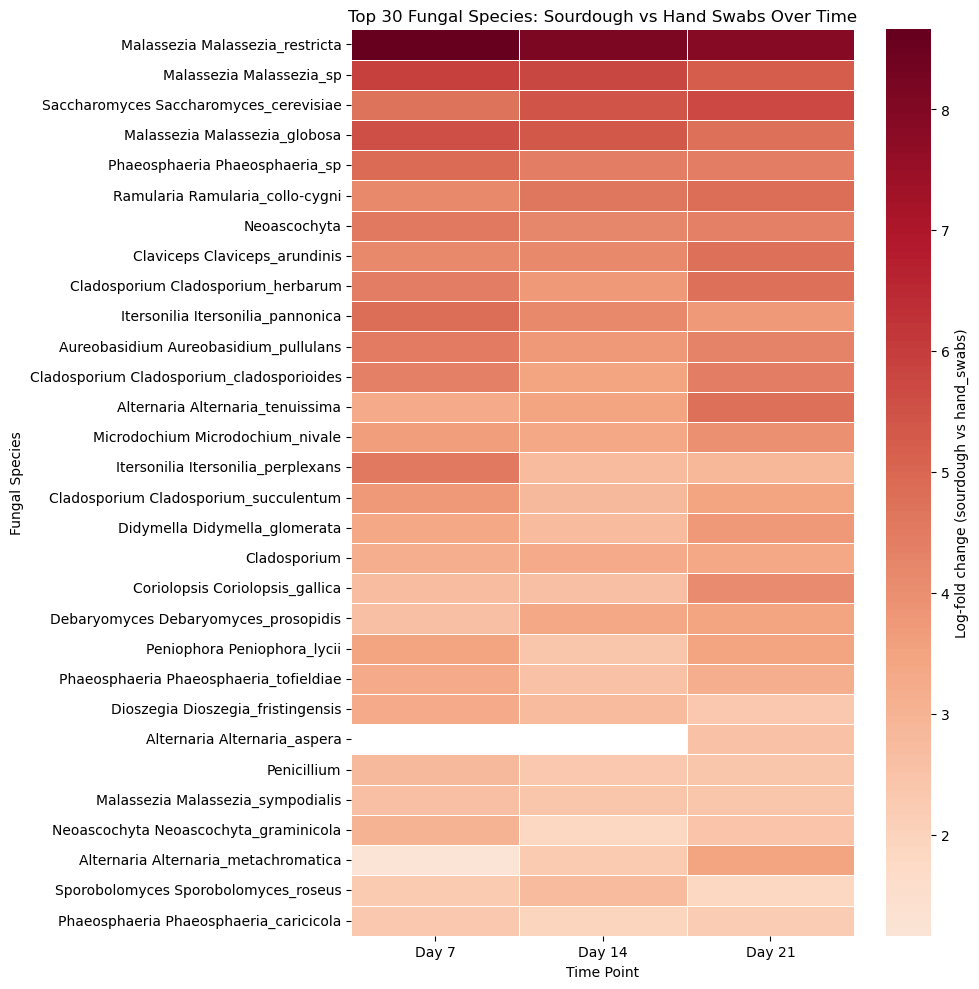

In [17]:
#Create heatmap once for sterile and once for non-sterile
# Create heatmap for hand_swabs vs sourdough
heatmap_data = []
for day, df in results_hand_vs_sourdough.items():
    significant = df[df['q_val'] < 0.05].copy()
    significant['day'] = f'Day {day}'
    
    # Extract ONLY genus and species
    def extract_genus_species(tax_string):
        parts = tax_string.split(';')
        genus = [p for p in parts if p.startswith('g__')]
        species = [p for p in parts if p.startswith('s__')]
        
        genus_name = genus[0].replace('g__', '').strip() if genus else ''
        species_name = species[0].replace('s__', '').strip() if species else ''
        
        if genus_name and species_name and species_name != '':
            return f"{genus_name} {species_name}"
        elif genus_name and genus_name != '':
            return genus_name
        else:
            return None
    
    significant['display_name'] = significant['id'].apply(extract_genus_species)
    significant = significant[significant['display_name'].notna()]
    
    heatmap_data.append(significant[['display_name', 'lfc', 'day']])

combined = pd.concat(heatmap_data, ignore_index=True)

# Filter for top taxa by absolute log-fold change
top_n = 30  # Adjust this number as needed
mean_abs_lfc = combined.groupby('display_name')['lfc'].apply(lambda x: abs(x).mean())
top_taxa = mean_abs_lfc.nlargest(top_n).index
combined_filtered = combined[combined['display_name'].isin(top_taxa)]

heatmap_matrix = combined_filtered.pivot(index='display_name', columns='day', values='lfc')

# Sort columns by day order (exclude Day 0 since it doesn't exist)
day_order = ['Day 7', 'Day 14', 'Day 21']
heatmap_matrix = heatmap_matrix.reindex(columns=day_order)

# Sort rows by hierarchical clustering or by mean LFC
row_order = heatmap_matrix.mean(axis=1).sort_values(ascending=False).index
heatmap_matrix = heatmap_matrix.reindex(row_order)

# Create heatmap with larger figure
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_matrix, cmap='RdBu_r', center=0, 
            cbar_kws={'label': 'Log-fold change (sourdough vs hand_swabs)'},
            linewidths=0.5, yticklabels=True)
plt.title(f'Top {top_n} Fungal Species: Sourdough vs Hand Swabs Over Time')
plt.xlabel('Time Point')
plt.ylabel('Fungal Species')
plt.tight_layout()
plt.show()

In [5]:
# Load your metadata to see sample types
metadata = pd.read_csv(f"{data_raw}/md_time.tsv", sep='\t')

# Check what sample types you have
print("Sample types available:")
print(metadata['sample_type'].value_counts())

# Check time points
print("\nTime points available:")
print(metadata['day'].value_counts())

# Check if you have hand samples
print("\nSample breakdown:")
print(metadata.groupby(['sample_type', 'day']).size())

Sample types available:
sample_type
hand_swabs    340
sourdough     125
Name: count, dtype: int64

Time points available:
day
7.0     127
14.0    127
21.0    113
0.0      98
Name: count, dtype: int64

Sample breakdown:
sample_type  day 
hand_swabs   0.0     98
             7.0     82
             14.0    86
             21.0    74
sourdough    7.0     45
             14.0    41
             21.0    39
dtype: int64
